# BPIC17 Simplified Next Activity Prediction - Training

Train a model that predicts both next activity AND lifecycle transition using only start/complete lifecycle transitions and END tokens for trace termination.

**Key Features:**
- Filters event log to only "start" and "complete" lifecycle transitions
- Adds END tokens at trace endings
- Dual output: activity + lifecycle prediction
- Optimized for BPIC 2017 event log


In [9]:
import sys
import os
import warnings
from pathlib import Path

# Add project root to path
project_root = Path(__file__).parent.parent.parent.parent if '__file__' in globals() else Path.cwd().parent.parent.parent
sys.path.insert(0, str(project_root))

# Add Next-Activity-Prediction to path
na_root = project_root / "Next-Activity-Prediction"
if str(na_root) not in sys.path:
    sys.path.insert(0, str(na_root))

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from bpic17_simplified import (
    load_and_filter_bpic17,
    add_end_tokens,
    BPIC17SimplifiedDataGenerator,
    BPIC17SimplifiedModel,
    BPIC17SimplifiedPersistence
)

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

print(f"Training started: {datetime.now()}")


Training started: 2026-01-06 23:56:00.587959


## 1. Configuration


In [10]:
# Paths
XES_PATH = os.path.join(project_root, "Dataset", "BPI Challenge 2017.xes")
MODEL_DIR = os.path.join(project_root, "models", "bpic17_simplified")
CHECKPOINT_DIR = os.path.join(MODEL_DIR, "checkpoints")

# Training parameters
MAX_HISTORY = 15
MIN_SAMPLES = 10
EPOCHS = 30
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.1
RANDOM_STATE = 42

# Model architecture
LSTM_UNITS = 256
HIDDEN_UNITS = 256

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"Model will be saved to: {MODEL_DIR}")


Model will be saved to: d:\Repos\process-simulation-engine\models\bpic17_simplified


## 2. Load and Preprocess Event Log


In [11]:
print(f"Loading and filtering BPIC 2017 event log...")
print(f"Log path: {XES_PATH}")

df_log = load_and_filter_bpic17(log_path=XES_PATH, lifecycle_filter=["start", "complete"])

print(f"\nFiltered log statistics:")
print(f"  Events: {len(df_log):,}")
print(f"  Cases: {df_log['case:concept:name'].nunique():,}")
print(f"\nLifecycle distribution:")
print(df_log['lifecycle:transition'].value_counts())


Loading and filtering BPIC 2017 event log...
Log path: d:\Repos\process-simulation-engine\Dataset\BPI Challenge 2017.xes

Filtered log statistics:
  Events: 603,533
  Cases: 31,509

Lifecycle distribution:
lifecycle:transition
complete    475306
start       128227
Name: count, dtype: int64


In [12]:
print("Adding END tokens to traces...")
df_log = add_end_tokens(df_log, end_token="END")

print(f"\nAfter adding END tokens:")
print(f"  Events: {len(df_log):,}")
print(f"  END tokens: {(df_log['concept:name'] == 'END').sum():,}")
print(f"\nActivity distribution (top 10):")
print(df_log['concept:name'].value_counts().head(10))


Adding END tokens to traces...

After adding END tokens:
  Events: 635,042
  END tokens: 31,509

Activity distribution (top 10):
concept:name
W_Validate application      55292
W_Complete application      49022
O_Create Offer              42995
O_Created                   42995
O_Sent (mail and online)    39707
A_Validating                38816
W_Call after offers         31827
A_Accepted                  31509
END                         31509
A_Create Application        31509
Name: count, dtype: int64


## 3. Generate Training Data


In [13]:
print("Generating training data...")
generator = BPIC17SimplifiedDataGenerator(
    df_log,
    max_history=MAX_HISTORY,
    min_samples=MIN_SAMPLES,
)

df_train = generator.generate()

print(f"\nGenerated {len(df_train):,} training sequences")
print(f"Unique target activities: {df_train['target_activity'].nunique()}")
print(f"Unique target lifecycles: {df_train['target_lifecycle'].nunique()}")

print(f"\nTarget activity distribution (top 10):")
print(df_train['target_activity'].value_counts().head(10))

print(f"\nTarget lifecycle distribution:")
print(df_train['target_lifecycle'].value_counts())


Generating training data...

Generated 603,529 training sequences
Unique target activities: 25
Unique target lifecycles: 2

Target activity distribution (top 10):
target_activity
W_Validate application      55292
W_Complete application      49022
O_Created                   42995
O_Create Offer              42995
O_Sent (mail and online)    39707
A_Validating                38816
W_Call after offers         31827
A_Accepted                  31509
A_Concept                   31509
END                         31509
Name: count, dtype: int64

Target lifecycle distribution:
target_lifecycle
complete    475306
start       128223
Name: count, dtype: int64


## 4. Train Model


In [14]:
print("Initializing model...")
model = BPIC17SimplifiedModel(
    max_seq_len=MAX_HISTORY,
    lstm_units=LSTM_UNITS,
    hidden_units=HIDDEN_UNITS,
)

checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_model.keras")

print(f"\nTraining model...")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Validation split: {VALIDATION_SPLIT}")

history = model.fit(
    df_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    checkpoint_path=checkpoint_path,
)


Initializing model...

Training model...
  Epochs: 30
  Batch size: 128
  Validation split: 0.1
Activity classes: 25, samples: 603529
  Most common: 55292 samples, Least common: 76 samples
Epoch 1/30
4244/4244 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - activity_accuracy: 0.7468 - activity_loss: 0.7387 - lifecycle_accuracy: 0.8560 - lifecycle_loss: 0.2882 - loss: 0.8252
Epoch 1: val_activity_accuracy improved from None to 0.86582, saving model to d:\Repos\process-simulation-engine\models\bpic17_simplified\checkpoints\best_model.keras

Epoch 1: finished saving model to d:\Repos\process-simulation-engine\models\bpic17_simplified\checkpoints\best_model.keras
4244/4244 ━━━━━━━━━━━━━━━━━━━━ 796s 185ms/step - activity_accuracy: 0.8231 - activity_loss: 0.4888 - lifecycle_accuracy: 0.8876 - lifecycle_loss: 0.2204 - loss: 0.5549 - val_activity_accuracy: 0.8658 - val_activity_loss: 0.3555 - val_lifecycle_accuracy: 0.9113 - val_lifecycle_loss: 0.1747 - val_loss: 0.4078 - learning_rate: 0.0010
Epoch 2/30

KeyboardInterrupt: 

## 5. Training History


NameError: name 'history' is not defined

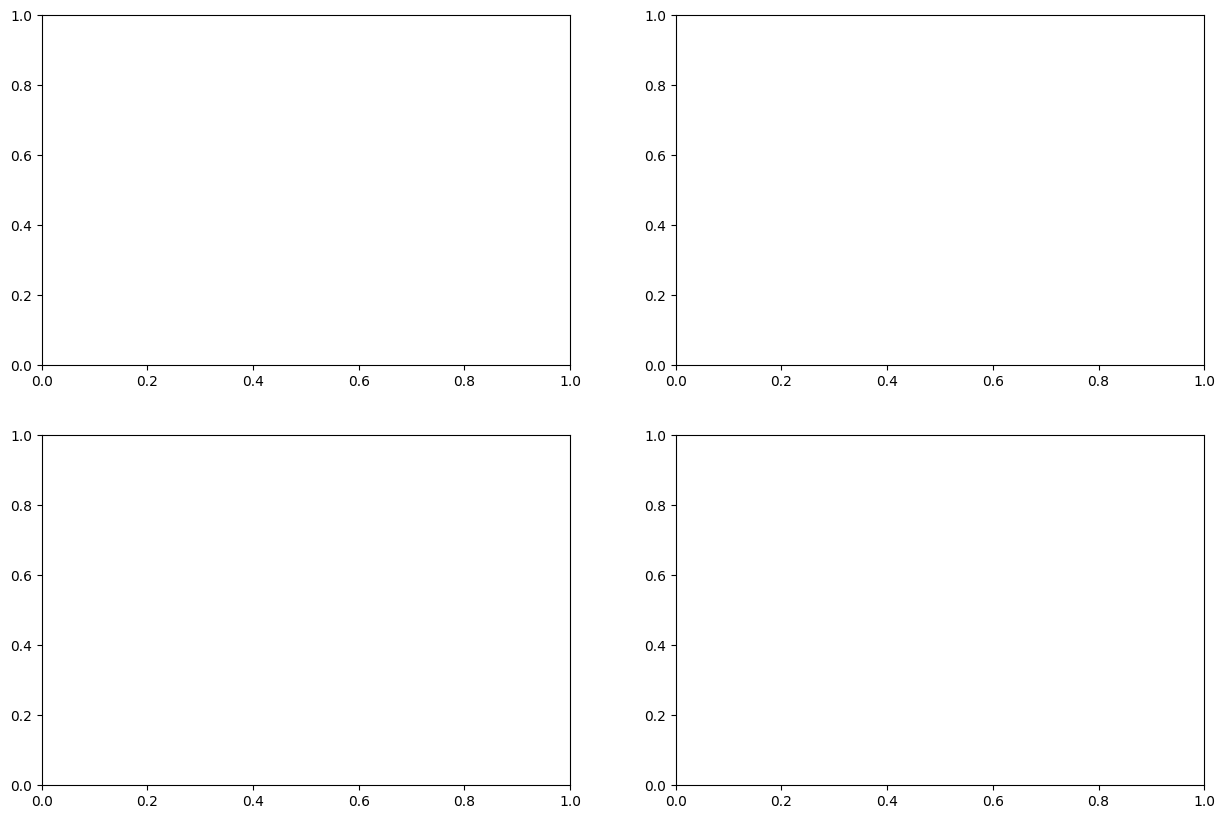

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Activity accuracy
axes[0, 0].plot(history.history['activity_accuracy'], label='Train')
axes[0, 0].plot(history.history['val_activity_accuracy'], label='Validation')
axes[0, 0].set_title('Activity Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Lifecycle accuracy
axes[0, 1].plot(history.history['lifecycle_accuracy'], label='Train')
axes[0, 1].plot(history.history['val_lifecycle_accuracy'], label='Validation')
axes[0, 1].set_title('Lifecycle Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Activity loss
axes[1, 0].plot(history.history['activity_loss'], label='Train')
axes[1, 0].plot(history.history['val_activity_loss'], label='Validation')
axes[1, 0].set_title('Activity Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Lifecycle loss
axes[1, 1].plot(history.history['lifecycle_loss'], label='Train')
axes[1, 1].plot(history.history['val_lifecycle_loss'], label='Validation')
axes[1, 1].set_title('Lifecycle Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"\nBest validation activity accuracy: {max(history.history['val_activity_accuracy']):.4f}")
print(f"Best validation lifecycle accuracy: {max(history.history['val_lifecycle_accuracy']):.4f}")


## 6. Save Model


In [15]:
print("Saving model...")
BPIC17SimplifiedPersistence.save(model, MODEL_DIR)

print(f"\nModel saved successfully to: {MODEL_DIR}")
print(f"Training completed at: {datetime.now()}")


Saving model...
Saved model to d:\Repos\process-simulation-engine\models\bpic17_simplified
  - model.keras
  - encoder.pkl
  - metadata.pkl

Model saved successfully to: d:\Repos\process-simulation-engine\models\bpic17_simplified
Training completed at: 2026-01-07 00:14:26.123186
